In [23]:
import pystan
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
gamma = """
data {
    real alpha;
    real beta;
}
generated quantities {
    real gamma = gamma_rng(alpha, beta);
}
"""
gamma_model = pystan.StanModel(model_code = gamma)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1c2bc928295618e7f5548bb882584208 NOW.


In [5]:
inv_gamma = """
data {
    real alpha;
    real beta;
}
generated quantities {
    real inv_gamma = inv_gamma_rng(alpha, beta);
}
"""
inv_gamma_model = pystan.StanModel(model_code = inv_gamma)
   

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ef2eb757f7ff60de5cf132a0f4f57ac4 NOW.


In [17]:
data = {'alpha': 3, 'beta': 2}
gamma_sam = gamma_model.sampling(data = data, algorithm = 'Fixed_param', iter = 1000)
inv_gamma_sam = inv_gamma_model.sampling(data = data, algorithm = 'Fixed_param', iter = 1000)
gamma_df = pd.DataFrame(gamma_sam.extract())
inv_gamma_df = pd.DataFrame(inv_gamma_sam.extract())
gamma_df.drop('lp__', axis = 1, inplace = True)
inv_gamma_df.drop('lp__', axis = 1, inplace = True)

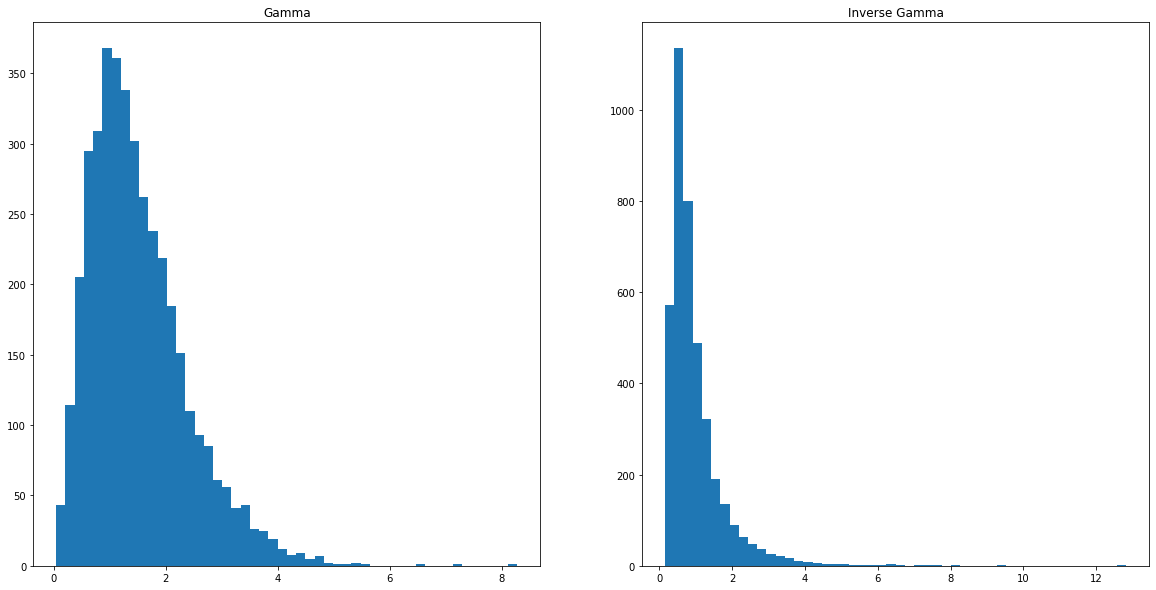

In [19]:
plt.figure(figsize = [20, 10])
plt.subplot(1, 2, 1).set_title("Gamma")
plt.hist(gamma_df['gamma'], bins = 50)
plt.subplot(1, 2, 2).set_title("Inverse Gamma")
plt.hist(inv_gamma_df['inv_gamma'], bins = 50)
plt.show()

In [20]:
gamma_solver = """
functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[3] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - exp(y[3]);
        gammas[2] = gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - exp(y[3]) - 0.98;
        gammas[3] = exp(y[1])/exp(y[2]) - 7;
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
    real probGuess;
}

transformed data {
    vector[3] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[3] y_guess = [log(alphaGuess), log(betaGuess), log(probGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}
"""
gamma_solver_model = pystan.StanModel(model_code = gamma_solver)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_868d74ecab1cbfb88f3dc2c4512d0fae NOW.


In [38]:
solver_data= {'lowerBound':5, 'upperBound':10, 'alphaGuess':11, 'betaGuess':1, 'probGuess':0.21}
gamma_solver_sam = gamma_solver_model.sampling(data = solver_data, algorithm = 'Fixed_param', iter = 1000)
alpha = np.round(gamma_solver_sam.extract()['alpha'][0])
beta = np.round(gamma_solver_sam.extract()['beta'][0])
print(f'alpha: {alpha}\nbeta: {beta}')

alpha: 47.0
beta: 7.0


In [39]:
tuned_gamma_data = {'alpha': alpha, 'beta': beta}
tuned_gamma_sam = gamma_model.sampling(data = tuned_gamma_data, algorithm = 'Fixed_param', iter = 1000)
tuned_gamma_df = pd.DataFrame(tuned_gamma_sam.extract())
tuned_gamma_df.drop('lp__', axis = 1, inplace = True)

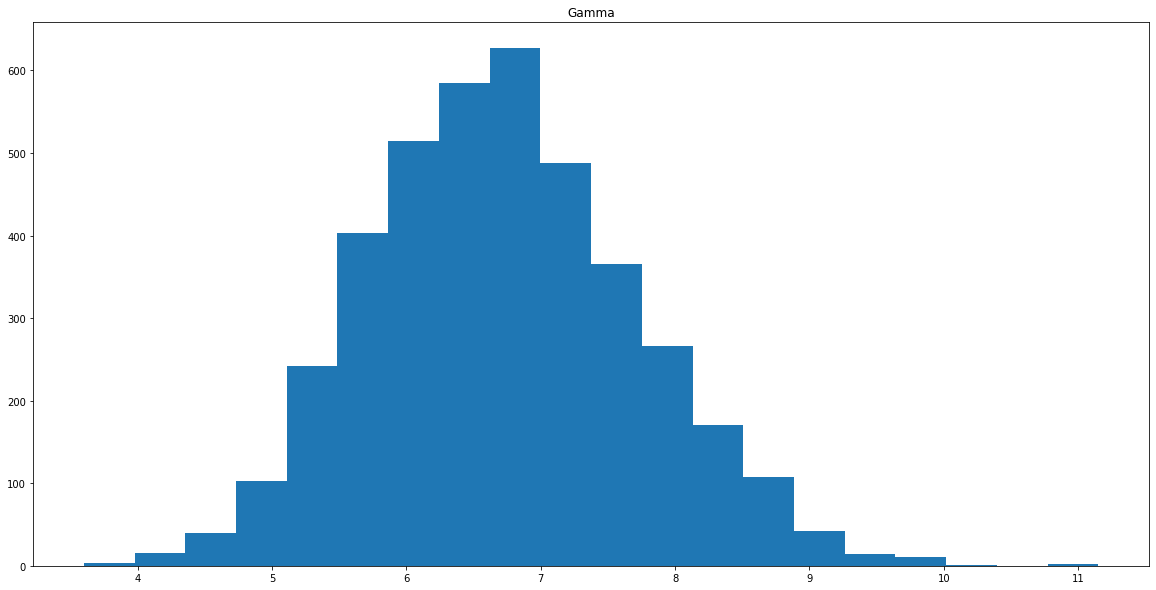

In [40]:
plt.figure(figsize = [20, 10])
plt.hist(tuned_gamma_df['gamma'], bins = 20)
plt.title('Gamma')
plt.show()

In [41]:
inv_gamma_solver = """
functions {
    vector gammaUnknown (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2])) - 0.98;
        return gammas;
    }
}

data {
    real lowerBound;
    real upperBound;
    real alphaGuess;
    real betaGuess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lowerBound, upperBound]';
    vector[2] y_guess = [log(alphaGuess), log(betaGuess)]';
    y = algebra_solver(gammaUnknown, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}
"""
inv_gamma_solver_model = pystan.StanModel(model_code = inv_gamma_solver)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c55240a1a480749b8d2342b4ae0f54db NOW.


In [47]:
inv_solver_data= {'lowerBound':5, 'upperBound':10, 'alphaGuess':11, 'betaGuess':72}
inv_gamma_solver_sam = inv_gamma_solver_model.sampling(data = inv_solver_data, algorithm = 'Fixed_param', iter = 1000)
alpha = np.round(inv_gamma_solver_sam.extract()['alpha'][0])
beta = np.round(inv_gamma_solver_sam.extract()['beta'][0])
print(f'alpha: {alpha}\nbeta: {beta}')

alpha: 40.0
beta: 280.0


In [48]:
tuned_inv_gamma_data = {'alpha': alpha, 'beta': beta}
tuned_inv_gamma_sam = inv_gamma_model.sampling(data = tuned_inv_gamma_data, algorithm = 'Fixed_param', iter = 1000)
tuned_inv_gamma_df = pd.DataFrame(tuned_inv_gamma_sam.extract())
tuned_inv_gamma_df.drop('lp__', axis = 1, inplace = True)

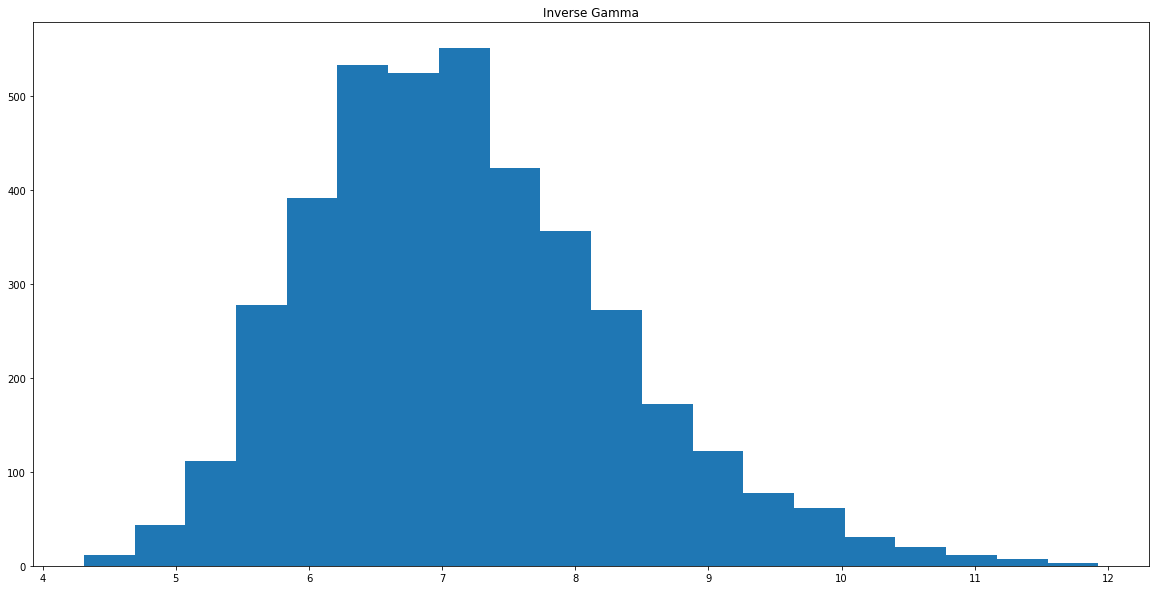

In [49]:
plt.figure(figsize = [20, 10])
plt.hist(tuned_inv_gamma_df['inv_gamma'], bins = 20)
plt.title('Inverse Gamma')
plt.show()